In [1]:
import os
import pytorchvideo.data
import torch
from torch.utils.data import DataLoader
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import TrainingArguments, Trainer
import evaluate

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
    MixUp,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

import imageio
import numpy as np
from IPython.display import Image

/home/myashka/miniconda3/envs/dl_tech/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/myashka/miniconda3/envs/dl_tech/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [2]:
class_labels = sorted(os.listdir("/home/myashka/dl_programming_tech/coin_dataset_classification/data/videos/train"))

In [3]:
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

In [4]:
print(f"Unique classes {len(list(label2id.keys()))}: {list(label2id.keys())}.")

Unique classes 12: ['Dish', 'DrinkandSnack', 'ElectricalAppliance', 'FurnitureandDecoration', 'Gadgets', 'Housework', 'LeisureandPerformance', 'NursingandCare', 'PetsandFruit', 'ScienceandCraft', 'Sport', 'Vehicle'].


In [6]:
model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
    torch_dtype=torch.float16
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
mean = image_processor.image_mean
std = image_processor.image_std
print(f"Mean: {mean}\nStd: {std}")
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)
print(f"Resize to {resize_to}")

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
print(f"Num frames to sample: {num_frames_to_sample}")
print(f"Sample rate: {sample_rate}")
print(f"Duration: {clip_duration} sec")

Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]
Resize to (224, 224)
Num frames to sample: 16
Sample rate: 4
Duration: 2.1333333333333333 sec


In [9]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

In [10]:
dataset_root_path = "/home/myashka/dl_programming_tech/coin_dataset_classification/data/videos"
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [11]:
print(f"Keys: {next(train_dataset).keys()}")
print(f"Video shape: {next(train_dataset)['video'].shape}")
print(f"Video name: {next(train_dataset)['video_name']}")
print(f"Clip index: {next(train_dataset)['clip_index']}")
print(f"Aug index: {next(train_dataset)['aug_index']}")
print(f"Label: {next(train_dataset)['label']}, {id2label[next(train_dataset)['label']]}")

Keys: dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])
Video shape: torch.Size([3, 16, 224, 224])
Video name: 0lyLaeGyR5U.mp4
Clip index: 0
Aug index: 0
Label: 4, FurnitureandDecoration


In [12]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        )
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [13]:
print(train_dataset.num_videos, val_dataset.num_videos)
print(f'Test data: {round(val_dataset.num_videos/(train_dataset.num_videos+val_dataset.num_videos)*100, 2)}%')

788 253
Test data: 24.3%


torch.Size([16, 3, 224, 224])


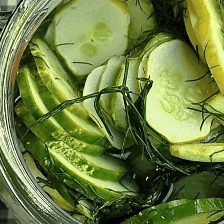

In [47]:
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [156]:
mix_up = MixUp(0.7, num_classes=12)

In [157]:
def collate_fn(examples):
    pixel_values = torch.stack(
        [example["video"] for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    pixel_values, labels = mix_up(pixel_values, labels)
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [pixel_value.permute(1, 0, 2, 3) for pixel_value in pixel_values]
    )
    labels = torch.argmax(labels, axis=1)
    return {"pixel_values": pixel_values, "labels": labels}

In [159]:
dl = DataLoader(train_dataset, 4, False, collate_fn=collate_fn)

In [160]:
batch = next(iter(dl))

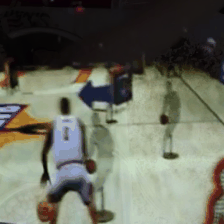

In [161]:
video_tensor = batch['pixel_values'][0]
gif_filename = create_gif(video_tensor, "sample.gif")
Image(filename=gif_filename)

In [35]:
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
accuracy_metric = evaluate.load("accuracy")

In [43]:
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(precision_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(accuracy_metric.compute(predictions=preds, references = labels))
    return results

In [ ]:
os.environ["WANDB_PROJECT"] = "ITMO_Video_lab"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-coin_domains"
num_epochs = 4
batch_size = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    seed=42,

    learning_rate=5e-5,
    weight_decay=0.05,
    max_grad_norm=1,
    optim="adamw_torch",

    lr_scheduler_type="cosine",
    warmup_ratio=0.1,

    fp16=True,
    gradient_checkpointing=True,

    evaluation_strategy="epoch",

    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    push_to_hub=False,

    logging_steps=1,
    report_to='wandb',
    run_name="train-videomae-domains"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)